In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
plt.rc("font", family = "MicroSoft YaHei", weight = "bold") # 防止中文乱码

#### 简单起见只考虑解
$$
\frac{1}{2}||y-x\beta||^2+\mu||\beta||_{1,2}
$$
#### 的问题，其中$\beta$是一维向量，解法是采用近似点梯度（可能先实现次梯度下降，效率不重要）

#### 相关系数聚类算法

In [182]:
def cor_means(k,x):
    dic = {}
    cls = {}
    for i in range(k):
        dic[i] = x[:,2*i]
        cls[i] = []
    it = 0
    while it < 10:
        for i in range(k):
            cls[i] = []
        for j in range(x.shape[1]):
            corr = [pd.Series(x[:,j]).corr(pd.Series(dic[i])) for i in range(k)]
            for s in range(k):
                if corr[s] == max(corr):
                    cls[s].append(j)
        for i in range(k):
            new_i = x[:,cls[i][0]]
            for j in range(1,len(cls[i])):
                new_i += x[:,cls[i][j]]
            dic[i] = new_i/np.linalg.norm(new_i,ord=2)
        it += 1
    corr = [pd.Series(x[:,3]).corr(pd.Series(dic[i])) for i in range(k)]
    #print(corr)
    return cls

#### 根据相关系数聚类得到分组

In [295]:
def find_div(k,x,beta):
    dic = cor_means(k,x)
    beta_new = np.zeros(beta.shape)
    x_new = np.zeros(x.shape)
    j = 0
    kk = 0
    div = []
    while j < x.shape[1]:
        s = len(dic[kk])
        beta_new[j:j+s] = beta[dic[kk]].copy()
        x_new[j:j+s,:] = x[dic[kk],:].copy()
        div.append([j,j+s])
        j += s
        kk += 1
    return x_new,beta_new,div

#### 关于给定分组的组LASSO的次梯度下降算法

In [321]:
#定义求值的函数
def f(y,x,beta,mu,div):
    return 0.5*np.linalg.norm(y-np.dot(x,beta), ord=2)**2+mu*g(beta,div)

def g(beta,div):
    s = 0
    for dd in div:
        s += np.linalg.norm(beta[dd[0]:dd[1]],ord=2)
    return s

def subgradient(beta,div):
    sub = np.zeros(beta.shape)
    for dd in div:
        if np.linalg.norm(beta[dd[0]:dd[1]])>0:
            sub[dd[0]:dd[1]] = beta[dd[0]:dd[1]]/np.linalg.norm(beta[dd[0]:dd[1]])
    return sub

def sub_dec(x,y,mu,beta0,div):
    k = 0
    t = 1e-5
    beta = beta0.copy()
    val = [f(y,x,beta,mu,div)]
    bb = [beta]

    while k < 500000:
        beta -= t*(np.dot(x.T,np.dot(x,beta)-y)+mu*subgradient(beta,div))
        ff = f(y,x,beta,mu,div)
        if abs(ff-val[-1]) < 1e-10:
            break
        val.append(ff)
        bb.append(beta)
        k += 1
        #t /= (k+1)/k
    return beta,val

def sparsity(beta):
    return np.sum(abs(beta)>1e-4*np.sum(abs(beta)))/len(beta)

#### Elastic Net的次梯度下降算法，传入分组为单个分组

In [297]:
#定义求值的函数
def e_f(y,x,beta,mu1,mu2,div):
    return 0.5*np.linalg.norm(y-np.dot(x,beta), ord=2)**2+e_g(beta,mu1,mu2,div)

def e_g(beta,mu1,mu2,div):
    s = 0
    for dd in div:
        s += mu1*np.linalg.norm(beta[dd[0]:dd[1]],ord=2)**2+mu2*np.linalg.norm(beta[dd[0]:dd[1]],ord=1)
    return s

def e_subgradient(beta,mu1,mu2,div):
    sub = np.zeros(beta.shape)
    for dd in div:
        if np.linalg.norm(beta[dd[0]:dd[1]])>0:
            sub[dd[0]:dd[1]] = 2*mu1*beta[dd[0]:dd[1]]
            for i in range(dd[0],dd[1]):
                if sub[i] > 0:
                    sub[i] += mu2
                else:
                    sub[i] -= mu2
    return sub

def elastic(x,y,mu1,mu2,beta0,div):
    k = 0
    t = 1e-5
    beta = beta0.copy()
    val = [e_f(y,x,beta,mu1,mu2,div)]
    bb = [beta]

    while k < 100000:
        beta -= t*(np.dot(x.T,np.dot(x,beta)-y)+e_subgradient(beta,mu1,mu2,div))
        ff = e_f(y,x,beta,mu1,mu2,div)
        if abs(ff-val[-1]) < 1e-10:
            break
        val.append(ff)
        bb.append(beta)
        k += 1
        #t /= (k+1)/k
    return beta,val

def sparsity(beta):
    return np.sum(abs(beta)>1e-4*np.sum(abs(beta)))/len(beta)

#### 生成数据，组内高度相关

In [311]:
p = 200 #beta的维度
n = 1000 #样本个数

#初始化真实的beta
beta = np.random.randn(p)
div = [[20*i,20*i+20] for i in range(p//20)] #分组方式
for i in range(p//20):
    if i%2 == 0:
        beta[div[i][0]:div[i][1]] = 0
    else:
        beta[div[i][0]:div[i][1]] = np.random.randint(100)/100+0.1*np.random.randn(div[i][1]-div[i][0])
x = np.zeros([n,p])
for i in range(p//20):
    x[:,20*i] = np.random.randn(n).T
    for s in range(1,20):
        x[:,20*i+s] = x[:,20*i]*(0.1+np.random.randint(10)/5)+0.1*np.random.randn(n).T
y = np.dot(x,beta)
y += 0.01*np.random.randn(n)

k = p//20
x_new,beta_new,div_new = find_div(k,x,beta)
y_new = np.dot(x_new,beta_new)
y_new += 0.001*np.random.randn(n)

#### 根据分组求解组LASSO

In [322]:
beta0 = np.random.rand(p)
mu = 1
beta_div,val_div = sub_dec(x_new,y_new,mu,beta0,div_new)

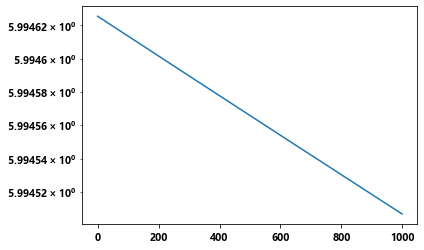

beta         [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.69989113 0.89866935 0.76652619 0.6928345
 0.71394288 0.64759136 0.65463165 0.83323199 0.59892183 0.71116766
 0.75147996 0.71857999 0.6869433  0.93841946 0.70684137 0.74371304
 0.88773256 0.70230109 0.73076146 0.9257633  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.26857744 0.19765326 0.05333404 0.07584865 0.17266638 0.05806743
 0.17775789 0.14666677 0.30293579 0.21630978 0.2325583  0.21624266
 0.04904708 0.23800778 0.2014518  0.18049214 0.13802001 0.19439707
 0.13147697 0.22562515 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        

In [326]:
plt.semilogy(val_div[-1000:])
plt.show()
print('beta        ',beta_new)
print('beta_div    ',beta_div)

In [324]:
print(f(y_new,x_new,beta_div,mu,div_new))
print(f(y_new,x_new,beta_new,mu,div_new))

5.994506686941153
13.07653705028261


#### 使用Elastic Net求解

In [315]:
div_e = [[i,i+1] for i in range(p)]
beta_ela,val_ela = elastic(x_new,y_new,0.5*mu,0.5*mu,beta0,div_e)

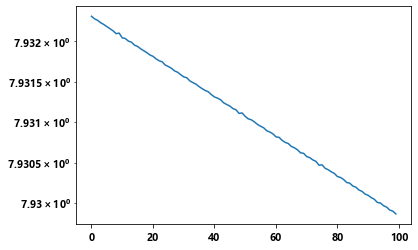

beta         [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.69989113 0.89866935 0.76652619 0.6928345
 0.71394288 0.64759136 0.65463165 0.83323199 0.59892183 0.71116766
 0.75147996 0.71857999 0.6869433  0.93841946 0.70684137 0.74371304
 0.88773256 0.70230109 0.73076146 0.9257633  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.26857744 0.19765326 0.05333404 0.07584865 0.17266638 0.05806743
 0.17775789 0.14666677 0.30293579 0.21630978 0.2325583  0.21624266
 0.04904708 0.23800778 0.2014518  0.18049214 0.13802001 0.19439707
 0.13147697 0.22562515 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        

In [316]:
plt.semilogy(val_ela[-100:])
plt.show()
print('beta        ',beta_new)
print('beta_ela    ',beta_ela)

In [317]:
print(e_f(y_new,x_new,beta_ela,0.5*mu,0.5*mu,div_e))
print(e_f(y_new,x_new,beta_new,0.5*mu,0.5*mu,div_e))

7.929865890843477
48.21503195916692


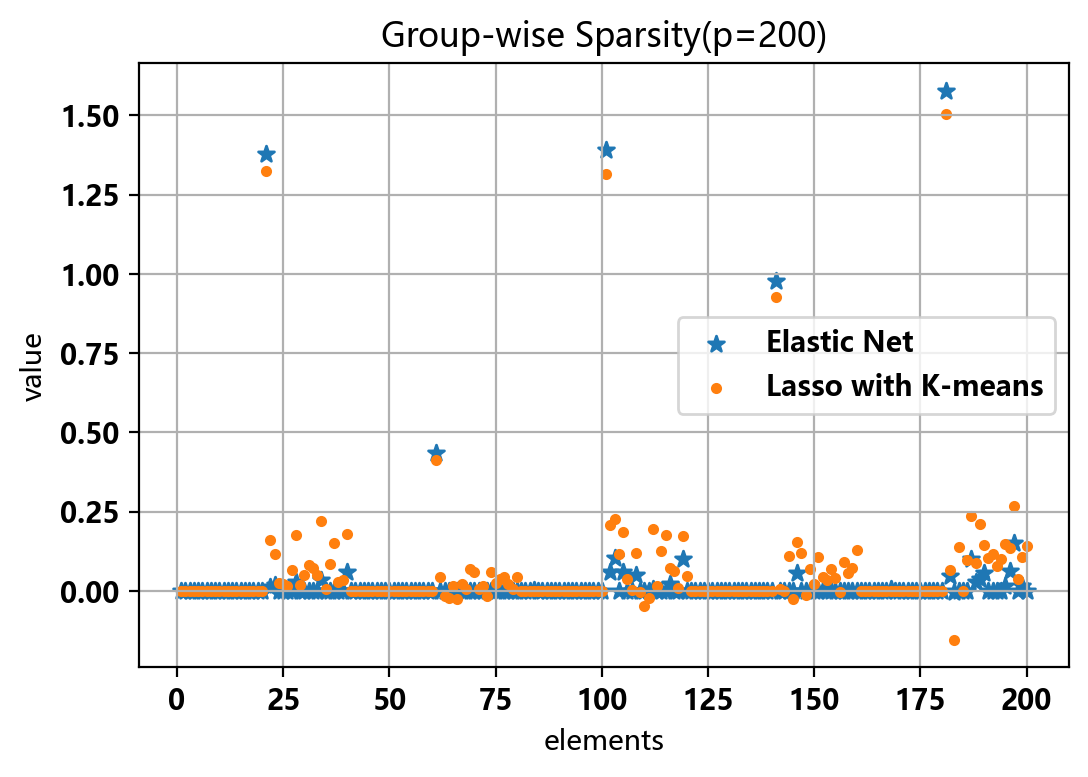

In [328]:
plt.figure(dpi=200)
#plt.scatter([i for i in range(1,21)],beta_ela)
plt.scatter([i for i in range(1,201)],beta_ela,marker='*')
plt.scatter([i for i in range(1,201)],beta_div,marker='.')
plt.grid(True)
plt.legend(['Elastic Net','Lasso with K-means'])
plt.title('Group-wise Sparsity(p=200)')
plt.xlabel('elements')
plt.ylabel('value')
plt.show()

In [335]:
def in_sparsity(beta,div):
    s = 0
    k = 0
    for dd in div:
        if np.linalg.norm(beta[dd[0]:dd[1]],ord=2) >= 1e-5*np.linalg.norm(beta,ord=2):
            k += dd[1]-dd[0]
            s += np.sum(abs(beta[dd[0]:dd[1]])>1e-3*np.linalg.norm(beta,ord=2))
    return s/k

In [336]:
print(in_sparsity(beta_div,div_new))
print(in_sparsity(beta_ela,div_new))

0.5388888888888889
0.155


#### 聚类算法的比较

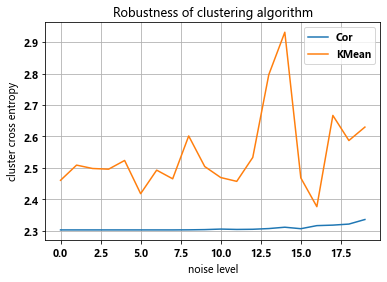

In [287]:
from sklearn.cluster import KMeans

p = 200 #beta的维度
n = 1000 #样本个数

cor_mean = []
K_mean = []

for noise in  range(20):
    beta = np.random.randn(p)
    div = [[20*i,20*i+20] for i in range(p//20)] #分组方式
    for i in range(p//20):
        if i%2 == 0:
            beta[div[i][0]:div[i][1]] = 0
        else:
            beta[div[i][0]:div[i][1]] = np.random.randint(100)/100+0.1*np.random.randn(div[i][1]-div[i][0])
    x = np.zeros([n,p])
    for i in range(p//20):
        x[:,20*i] = np.random.randn(n).T
        for s in range(1,20):
            x[:,20*i+s] = x[:,20*i]*(0.1+np.random.randint(10)/5)+10**(-1+noise/8)*np.random.randn(n).T
    y = np.dot(x,beta)
    y += 0.01*np.random.randn(n)
    
    K_result = KMeans(n_clusters=10,random_state=9).fit_predict(x.T)
    cor = cor_means(10,x)
    res = [0 for i in range(10)]
    ress = [0 for i in range(10)]
    for k in range(10):
        res[k] = np.sum(K_result==k)/p
        ress[k] = len(cor[k])/p
    s = 0
    cor_mean.append(0)
    K_mean.append(0)
    for k in range(10):
        cor_mean[-1] -= 0.1*np.log(ress[k])
        K_mean[-1] -= 0.1*np.log(res[k])

plt.plot(cor_mean)
plt.plot(K_mean)
plt.legend(['Cor','KMean'])
plt.grid(True)
plt.xlabel('noise level')
plt.ylabel('cluster cross entropy')
plt.title('Robustness of clustering algorithm')
plt.show()

In [267]:
res

[0.045, 0.37, 0.07, 0.085, 0.075, 0.075, 0.07, 0.085, 0.06, 0.065]

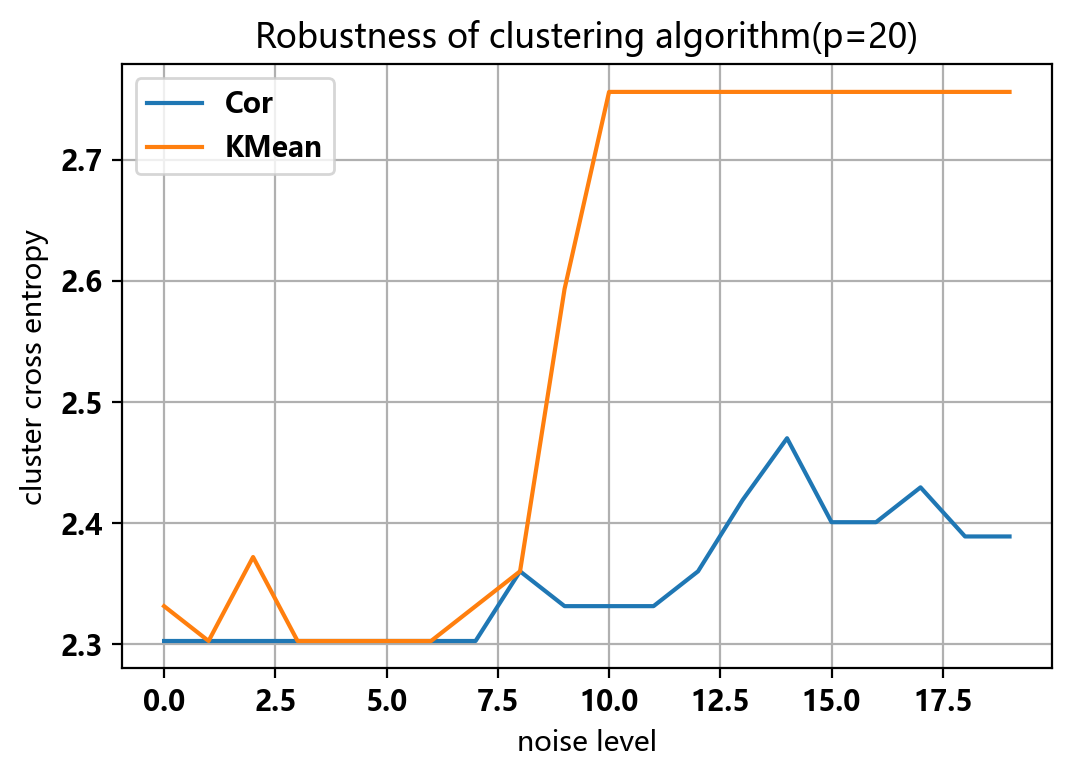

In [332]:
plt.figure(dpi=200)
plt.plot(cor_mean)
plt.plot(K_mean)
plt.legend(['Cor','KMean'])
plt.grid(True)
plt.xlabel('noise level')
plt.ylabel('cluster cross entropy')
plt.title('Robustness of clustering algorithm(p=20)')

plt.show()

In [309]:
def cor_means(k,x):
    dic = {}
    cls = {}
    for i in range(k):
        dic[i] = x[:,20*i]
        cls[i] = []
    it = 0
    while it < 1:
        for i in range(k):
            cls[i] = []
        for j in range(x.shape[1]):
            corr = [pd.Series(x[:,j]).corr(pd.Series(dic[i])) for i in range(k)]
            s = 0
            for ss in range(k):
                if corr[ss] >= corr[s]:
                    s = ss
            cls[s].append(j)
        for i in range(k):
            new_i = x[:,cls[i][0]]
            for j in range(1,len(cls[i])):
                new_i += x[:,cls[i][j]]
            dic[i] = new_i/np.linalg.norm(new_i,ord=2)
        it += 1
    corr = [pd.Series(x[:,3]).corr(pd.Series(dic[i])) for i in range(k)]
    #print(corr)
    return cls

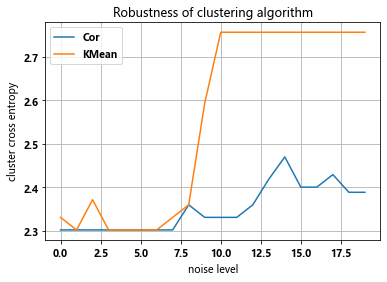

In [292]:
from sklearn.cluster import KMeans

p = 20 #beta的维度
n = 100 #样本个数

cor_mean = []
K_mean = []

for noise in  range(20):
    beta = np.random.randn(p)
    div = [[2*i,2*i+2] for i in range(p//2)] #分组方式
    for i in range(p//2):
        if i%2 == 0:
            beta[div[i][0]:div[i][1]] = 0
        else:
            beta[div[i][0]:div[i][1]] = np.random.randint(100)/100+0.1*np.random.randn(div[i][1]-div[i][0])
    x = np.zeros([n,p])
    for i in range(p//2):
        x[:,2*i] = np.random.randn(n).T
        for s in range(1,2):
            x[:,2*i+s] = x[:,2*i]*(np.random.randint(10)/5+0.1)+10**(-1+noise/8)*np.random.randn(n).T
    y = np.dot(x,beta)
    y += 0.01*np.random.randn(n)
    
    K_result = KMeans(n_clusters=10,random_state=9).fit_predict(x.T)
    cor = cor_means(10,x)
    res = [0 for i in range(10)]
    ress = [0 for i in range(10)]
    for k in range(10):
        res[k] = np.sum(K_result==k)/p
        ress[k] = len(cor[k])/p
    s = 0
    cor_mean.append(0)
    K_mean.append(0)
    for k in range(10):
        cor_mean[-1] -= 0.1*np.log(ress[k])
        K_mean[-1] -= 0.1*np.log(res[k])

x = [10**(-2+noise/4) for noise in  range(20)]
plt.plot(cor_mean)
plt.plot(K_mean)
plt.legend(['Cor','KMean'])
plt.grid(True)
plt.xlabel('noise level')
plt.ylabel('cluster cross entropy')
plt.title('Robustness of clustering algorithm')
plt.show()

In [284]:
np.corrcoef(x.T)[21]

array([ 0.42580739,  0.41539053,  0.43700282,  0.4253738 ,  0.42237983,
        0.42195312,  0.42122357,  0.3366855 ,  0.42646771,  0.41271045,
        0.4219093 ,  0.27367523,  0.42351957,  0.40016963,  0.4237202 ,
        0.40747759,  0.42635495,  0.42613152,  0.42082989,  0.39976874,
        0.04034011,  1.        ,  0.42951817,  0.3983384 ,  0.43988683,
        0.2004672 ,  0.40032901,  0.39813929,  0.43200055,  0.42501397,
        0.43707918,  0.20340982,  0.42606408,  0.42011544,  0.43548305,
        0.43706822,  0.43477129,  0.43381035,  0.44152568,  0.41620307,
       -0.02778832,  0.42197539,  0.4167295 ,  0.41761527,  0.37101242,
        0.42224721,  0.41658117,  0.41391986,  0.42218882,  0.42155211,
        0.42256664,  0.42336975,  0.4212972 ,  0.41738591,  0.41926115,
        0.42253181,  0.42221994,  0.4204504 ,  0.42141118,  0.36256617,
        0.02461647,  0.39554683,  0.41859892,  0.40815044,  0.41736579,
        0.27940943,  0.39247163,  0.42070783,  0.40175619,  0.41

In [248]:
corr = [pd.Series(x[:,0]).corr(pd.Series(dic[i])) for i in range(10)]

In [247]:
dic = {}
cls = {}
for i in range(10):
    dic[i] = x[:,2*i]
    cls[i] = []

In [257]:
s = 0
k = 10
for ss in range(k):
    if corr[ss] >= corr[s]:
        print(ss)
        s = ss
cls[s].append(0)

0


In [258]:
cls

{0: [0], 1: [], 2: [0, 0, 0], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

In [255]:
corr

[1.0,
 -0.009188212052593465,
 0.04572491857907307,
 0.05509639250016103,
 -0.1357870337855281,
 0.15021621405076577,
 0.1802666182457979,
 0.058389700601577645,
 0.048119971591162276,
 -0.012528287578185117]

In [243]:
[pd.Series(x[:,0]).corr(pd.Series(dic[i])) for i in range(10)]

[0.09511670895673217,
 -0.2540905399961776,
 0.00839112253142388,
 0.1782323461008522,
 0.09637402882577921,
 -0.05477471403544715,
 0.008043093637224032,
 -0.04640112403417217,
 -0.158378378329405,
 0.06470058462987581]

In [246]:
x.T[0]

array([-0.19225137, -0.90940045,  0.71331321,  0.43631339,  0.08996242,
        0.3843592 , -0.63486024, -0.14145639,  0.32967808,  0.55585676,
       -0.06037689,  1.85778996, -1.10818844,  1.32206566,  0.05374369,
       -0.29899557, -0.60656605,  0.21365199,  0.08631151,  0.22336565,
        1.71599812, -0.013387  , -2.10182205,  0.49263008, -1.05130107,
       -0.04315152, -0.84418842,  0.83257577, -0.19055   , -2.47735733,
       -1.8346804 , -0.54926226, -0.54948047,  0.26395333,  0.21295546,
       -1.33198219, -0.18386382, -0.20418277, -0.07078764,  0.32639176,
       -1.02960954,  0.08434752,  1.10103028,  0.27489286, -0.75449482,
        1.46149581,  0.13403668, -2.26868259,  0.33967   ,  1.49687607,
        0.83128449,  0.87272918, -0.78134474,  0.80865175, -0.11222132,
        1.66960226, -0.99712039, -0.44243556, -0.69762509, -1.08023486,
        1.03560188,  0.00381021,  0.61799038,  0.47461608,  0.0512117 ,
        0.69235228, -0.16069364, -0.35850213,  0.09301998,  0.88